In [1]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

PATH = '../'
MODELDATA = os.path.join(PATH, 'landcover/model_outputs/lcm20/')
SITEDATA = os.path.join(PATH, 'site_data')

data_paths = {
    'nlees_grid': os.path.join(SITEDATA, 'north_lees', 'grid_64m_buff_2km.shp'),
    'nlees_full_grid': os.path.join(SITEDATA, 'north_lees', 'grid_64_full_nlees.shp'),
    'morridge_grid': os.path.join(SITEDATA, 'morridge', 'grid_64m_buff_2km.shp'),
    'morridge_full_grid': os.path.join(SITEDATA, 'morridge', 'grid_64m_full_morridge.shp')
}

## Morridge

In [3]:
group = []
sample_grid = gpd.read_file(data_paths['morridge_grid'])

for k100 in tqdm(['SJ96', 'SK06', 'SK05', 'SK07', 'SK15', 'SK16']):
    tile = 'merged_predictions_LCU_detailed-combined_section-' + k100
    
    lcm20 = gpd.read_file(
        os.path.join(MODELDATA, tile, tile, tile+'.shp'),
        mask=sample_grid # Filter
    )
    
    # Don't dissove, too time consuming
    predictions = lcm20[lcm20['source']=='model prediction']
    classes = predictions[['lc_label', 'geometry']]
    
    classes_exp = classes.reset_index()
    classes_exp['area'] = classes_exp['geometry'].area
    
    group.append(classes_exp)


  0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
classes_exp = pd.concat(group)

In [5]:
classes_exp.head(2)

,index,lc_label,geometry,area
0,3,C1,"POLYGON ((399431.875 368989.625, 399432.25 368...",0.515625
1,4,C4a,"POLYGON ((399431.25 368989.375, 399431.375 368...",5.859375


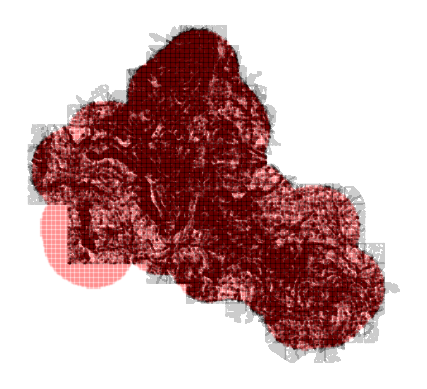

In [5]:
fig, ax = plt.subplots()

classes_exp.plot(color='none', edgecolor='black', alpha=.2, ax=ax)
sample_grid.plot(color='none', edgecolor='red', alpha=.1, ax=ax)

ax.axis('off');

In [6]:
sample_grid['id'] = sample_grid['id'].astype(int)
pop = sample_grid[['id', 'geometry']].overlay(
    classes_exp, how='intersection',
    keep_geom_type=True
) # takes ages

pop['area'] = pop['geometry'].area # No auto update

In [7]:
pop_diss = pop.groupby('id', as_index=True).apply(
    lambda x: x.dissolve(by='lc_label'),
    include_groups=False
)

pop_diss['area'] = pop_diss['geometry'].area

In [8]:
full_sqs = pop_diss.groupby('id')['area'].sum()==64**2
full_indx = full_sqs[full_sqs.values].index

pop_diss_full = pop_diss.loc[full_indx]

In [9]:
idx = pop_diss_full.groupby('id')['area'].idxmax()
max_by_class = pop_diss_full.loc[idx]

In [10]:
max_by_class = max_by_class.reset_index()
max_by_class.head()

,id,lc_label,geometry,index,area
0,6060,E2a,"MULTIPOLYGON (((394199.5 365168.375, 394199.62...",182078,3169.765625
1,6061,E2a,"POLYGON ((394197.25 365168, 394197.375 365168,...",182726,4021.531250
2,6062,E2a,"POLYGON ((394216 365104, 394216 365040, 394152...",182726,4096.000000
3,6063,E2a,"POLYGON ((394152 364976, 394152 365000, 394152...",39910,4096.000000
4,6064,E2a,"MULTIPOLYGON (((394160 364942.375, 394160.125 ...",39556,3838.312500


In [13]:
counts = max_by_class.groupby('lc_label').count().reset_index()

n = 60
gt_n = counts[counts['area']>=n]['lc_label'].tolist()
lt_n = counts[counts['area']<n]['lc_label'].tolist()

In [14]:
sub_lt_n = max_by_class[max_by_class['lc_label'].isin(lt_n)]
sub_gt_n = max_by_class[max_by_class['lc_label'].isin(gt_n)]

In [15]:
rng = np.random.default_rng(seed=42)

samples = sub_gt_n.groupby('lc_label').sample(n=n, random_state=rng)
samples = samples.reset_index().set_index('id')

samples = pd.concat([samples, sub_lt_n.reset_index().set_index('id')])
#samples.groupby('lc_label').count()[['class']]

In [77]:
sel = samples.reset_index()['id']
grid = sample_grid.set_index('id')
grid_sel = grid.loc[sel]

#grid_sel.to_file(os.path.join(SITEDATA, 'test.shp'))

In [78]:
full_grid = gpd.read_file(data_paths['morridge_full_grid'])

In [84]:
def filter_overlaps(gdf, d):
    buff = gdf.copy()
    buff['geometry'] = buff.centroid.buffer(d/2)
    overlaps =buff.sjoin(buff, how='left', predicate='intersects').reset_index()
    overlaps_filter = overlaps.loc[overlaps.groupby('id_right')['id_left'].idxmin()]
    indices = overlaps_filter.groupby('id_left')['id_right'].idxmin()
    return overlaps_filter.loc[indices]['id_right']

filt = grid_sel.loc[filter_overlaps(grid_sel, 200)]
filt2 = grid_sel.loc[filter_overlaps(filt, 200)]
filt3 = grid_sel.loc[filter_overlaps(filt2, 200)]# Triple up to remove clusters

In [85]:
final = full_grid.sjoin(filt3, how='inner').dissolve(by='id_right')
final = final.reset_index()[['id_right', 'geometry']]
final.columns = ['sample_sq', 'geometry']

#final.to_file(os.path.join(SITEDATA, 'morridge', 'morridge_sample_sqi.shp'))

In [16]:
sample_lcm20 = final.overlay(
    classes_exp, how='intersection',
    keep_geom_type=True
)

In [88]:
sample_lcm20['area'] = sample_lcm20['geometry'].area

sample_cls_areas = (
    sample_lcm20[['lc_label', 'area']]
    .groupby('lc_label')
    .sum()
    .reset_index()
)

In [90]:
classes_tots = (
    classes_exp[['lc_label', 'area']]
    .groupby('lc_label')
    .sum()
    .reset_index()
)

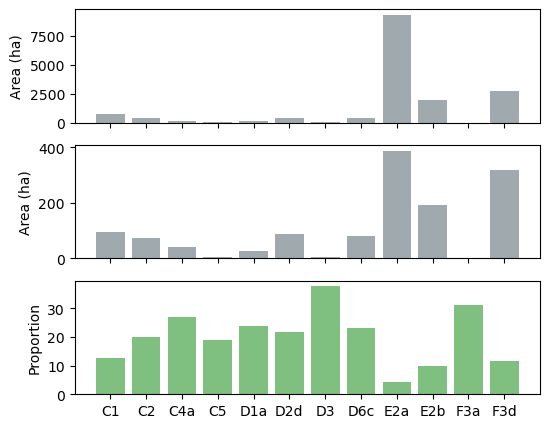

In [92]:
fig, ax = plt.subplots(3, 1, figsize=(6, 5), sharex=True)

ax[0].bar(classes_tots['lc_label'], classes_tots['area']/10000, facecolor='#899499', alpha=.8)
ax[0].set_ylabel('Area (ha)');

ax[1].bar(sample_cls_areas['lc_label'], sample_cls_areas['area']/10000, facecolor='#899499', alpha=.8)
ax[1].set_ylabel('Area (ha)')

ax[2].bar(
    sample_cls_areas['lc_label'],
    sample_cls_areas['area']/classes_tots['area']*100,
    facecolor='g',
    alpha=.5
)
ax[2].set_ylabel('Proportion');

In [11]:
final = gpd.read_file(os.path.join(SITEDATA, 'morridge', 'morridge_sample_sqi.shp'))
final.head(2)

,sample_sq,geometry
0,7715,"POLYGON ((394600 364464, 394536 364464, 394472..."
1,8390,"POLYGON ((394728 363376, 394664 363376, 394600..."


In [17]:
max_by_class_samp = samples.loc[sample_lcm20['sample_sq'].unique()]

In [18]:
rng = np.random.default_rng(seed=42)
train_idx = max_by_class_samp.groupby('lc_label').sample(frac=.7, random_state=rng).index

sel = final['sample_sq'].isin(train_idx)
train = final[sel]
test = final[~sel]

In [19]:
assert (pd.concat([train, test]).sort_index().index==final.index).all()

In [20]:
train.to_file(os.path.join(SITEDATA, 'morridge', 'mordg_sample_sqi_train.shp'))
test.to_file(os.path.join(SITEDATA, 'morridge', 'mordg_sample_sqi_test.shp'))

## North Lees

In [94]:
tile = 'merged_predictions_LCU_detailed-combined_section-SK28'

sample_grid = gpd.read_file(data_paths['nlees_grid'])

lcm20 = gpd.read_file(
    os.path.join(MODELDATA, tile, tile+'.shp'),
    mask=sample_grid # Filter
)

lcm20.head()

,class,lc_label,source,Class name,area,pol_id_til,geometry
0,1,C1,model prediction,Broadleaved High Forest,35.953125,0,"POLYGON ((423039.875 386718.5, 423042.25 38671..."
1,4,C4a,model prediction,Scrub,172.625000,1,"POLYGON ((423876.625 386017.125, 423876.625 38..."
2,4,C4a,model prediction,Scrub,90.953125,2,"POLYGON ((423193.5 386044.875, 423193.625 3860..."
3,4,C4a,model prediction,Scrub,49.609375,3,"POLYGON ((423685.75 386137.875, 423685.75 3861..."
4,4,C4a,model prediction,Scrub,71.125000,4,"POLYGON ((423740.25 386161.5, 423740.125 38616..."


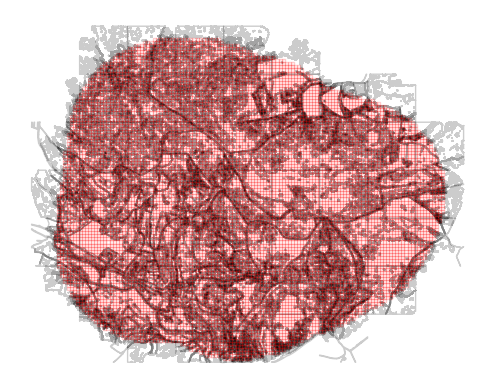

In [18]:
fig, ax = plt.subplots()

lcm20.plot(color='none', edgecolor='black', alpha=.2, ax=ax)
sample_grid.plot(color='none', edgecolor='red', alpha=.1, ax=ax)

ax.axis('off');

Get the total class areas within the study area (overlapping).

In [95]:
predictions = lcm20[lcm20['source']=='model prediction']
classes = predictions[['class', 'lc_label', 'geometry']].dissolve(by='lc_label')

Overlay the priors with the sample grid, maintaining useful features from both.

In [96]:
classes_exp = classes.reset_index().explode(index_parts=False)
classes_exp['area'] = classes_exp['geometry'].area

In [97]:
sample_grid['id'] = sample_grid['id'].astype(int)
pop = sample_grid[['id', 'geometry']].overlay(
    classes_exp, how='intersection',
    keep_geom_type=True
) # takes ages

pop['area'] = pop['geometry'].area # No auto update

In [106]:
#pop_export = pop.explode(index_parts=False)
#pop_export['area'] = pop_export['geometry'].area
#pop_export.to_file(data_paths['nlees_grid'][:-4] + '_lcm20_atts.shp')

Dissolve by label within each grid square (i.e. one class multipolygon per grid)

In [98]:
pop_diss = pop.groupby('id', as_index=True).apply(
    lambda x: x.dissolve(by='lc_label'),
    include_groups=False
)

pop_diss['area'] = pop_diss['geometry'].area

Select only whole squares

In [99]:
full_sqs = pop_diss.groupby('id')['area'].sum()==64**2
full_indx = full_sqs[full_sqs.values].index

pop_diss_full = pop_diss.loc[full_indx]

Get max. class within each square by area, this is to identify squares with significant amounts of each class.

In [100]:
idx = pop_diss_full.groupby('id')['area'].idxmax()
max_by_class = pop_diss_full.loc[idx]

#max_by_class.groupby('lc_label').count()[['class']]

Random sample within the classes

In [101]:
rng = np.random.default_rng(seed=42)

samples = max_by_class.groupby('lc_label').sample(n=16, random_state=rng)
samples = samples.reset_index().set_index('id')
#samples.groupby('lc_label').count()[['class']]

In [132]:
sel = samples.reset_index()['id']
grid = sample_grid.set_index('id')
grid_sel = grid.loc[sel]

#grid_sel.to_file(os.path.join(SITEDATA, 'test.shp'))

Remove samples within two grid squares (~200 m)

In [133]:
def filter_overlaps(gdf, d):
    buff = gdf.copy()
    buff['geometry'] = buff.centroid.buffer(d/2)
    overlaps =buff.sjoin(buff, how='left', predicate='intersects').reset_index()
    overlaps_filter = overlaps.loc[overlaps.groupby('id_right')['id_left'].idxmin()]
    indices = overlaps_filter.groupby('id_left')['id_right'].idxmin()
    return overlaps_filter.loc[indices]['id_right']

filt = grid_sel.loc[filter_overlaps(grid_sel, 200)]
filt2 = grid_sel.loc[filter_overlaps(filt, 200)] # Double up to remove clusters
#filt2.to_file(os.path.join(SITEDATA, 'test2.shp'))

Expand to 3x3 square samples, load the full grid to avoid partial squares.

In [214]:
full_grid = gpd.read_file(data_paths['nlees_full_grid'])
full_grid.head()

,id,left,top,right,bottom,geometry
0,1.0,419000.0,389000.0,419064.0,388936.0,"POLYGON ((419000 389000, 419064 389000, 419064..."
1,2.0,419000.0,388936.0,419064.0,388872.0,"POLYGON ((419000 388936, 419064 388936, 419064..."
2,3.0,419000.0,388872.0,419064.0,388808.0,"POLYGON ((419000 388872, 419064 388872, 419064..."
3,4.0,419000.0,388808.0,419064.0,388744.0,"POLYGON ((419000 388808, 419064 388808, 419064..."
4,5.0,419000.0,388744.0,419064.0,388680.0,"POLYGON ((419000 388744, 419064 388744, 419064..."


In [220]:
final = full_grid.sjoin(filt2, how='inner').dissolve(by='id_right')
final = final.reset_index()[['id_right', 'geometry']]
final.columns = ['sample_sq', 'geometry']

#final.to_file(os.path.join(SITEDATA, 'north_lees', 'nless_sample_sqi.shp'))

In [136]:
sample_lcm20 = final.overlay(
    classes_exp,
    how='intersection',
    keep_geom_type=True
)

In [145]:
#sample_lcm20.to_file(os.path.join(SITEDATA, 'north_lees', 'nless_sample_sqi_overlay.shp'))

In [158]:
max_by_class_samp = samples.loc[sample_lcm20['sample_sq'].unique()]

Split 70/30 for training and testing

In [221]:
rng = np.random.default_rng(seed=42)
train_idx = max_by_class_samp.groupby('lc_label').sample(frac=.7, random_state=rng).index

sel = final['sample_sq'].isin(train_idx)
train = final[sel]
test = final[~sel]

In [222]:
assert (pd.concat([train, test]).sort_index().index==final.index).all()

In [223]:
train.to_file(os.path.join(SITEDATA, 'north_lees', 'nless_sample_sqi_train.shp'))
test.to_file(os.path.join(SITEDATA, 'north_lees', 'nless_sample_sqi_test.shp'))

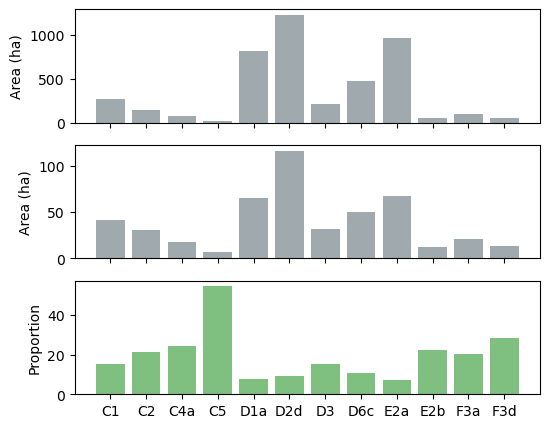

In [605]:
fig, ax = plt.subplots(3, 1, figsize=(6, 5), sharex=True)

sample_cls_areas['area'] = sample_cls_areas['geometry'].area
classes['area'] = classes['geometry'].area

ax[0].bar(classes.index, classes['area']/10000, facecolor='#899499', alpha=.8)
ax[0].set_ylabel('Area (ha)');

ax[1].bar(sample_cls_areas.index, sample_cls_areas['area']/10000, facecolor='#899499', alpha=.8)
ax[1].set_ylabel('Area (ha)')

ax[2].bar(
    sample_cls_areas.index,
    sample_cls_areas['area']/classes['area']*100,
    facecolor='g',
    alpha=.5
)
ax[2].set_ylabel('Proportion');